In [1]:
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from tqdm import tqdm_notebook
import sounddevice as sd
import scipy.fftpack
from scipy import signal
from scipy.optimize import curve_fit
from statsmodels.robust import mad

%matplotlib inline

In [2]:
data = np.loadtxt('ff2.txt')

In [3]:
data_len = len(data)
print("Довжина масиву: {}".format(data_len))

Довжина масиву: 65536


# 1. Попередній аналіз

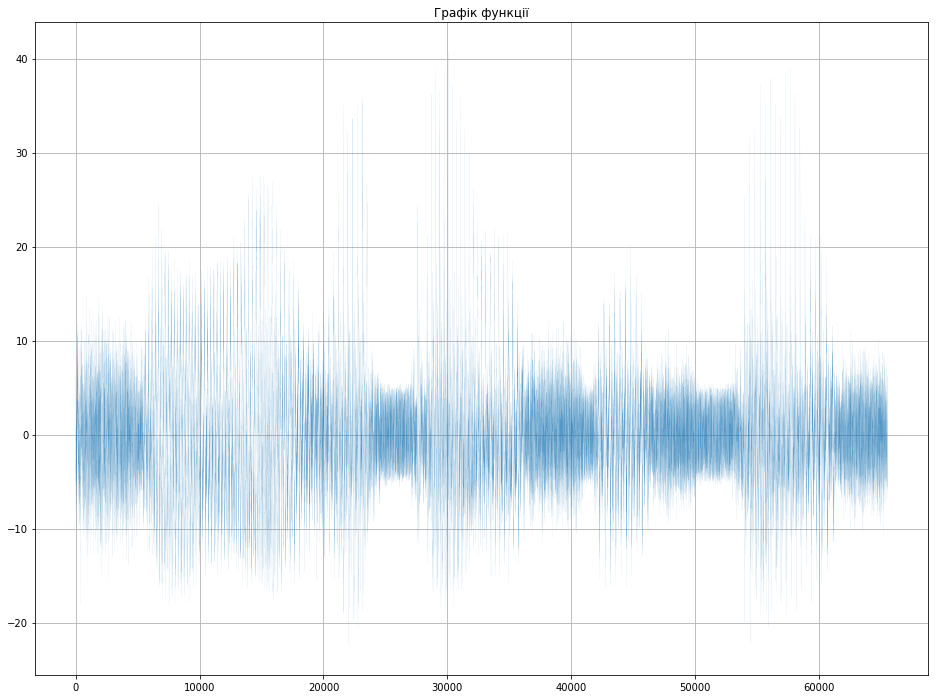

In [4]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.title("Графік функції")
plt.plot(np.arange(data_len), data, alpha=0.75, linewidth=0.05);

Схоже на аудіо, перевіримо дану  гіпотезу експерементальним методом <br> 
Для цього переведемо масив в аудіо і прослухаємо при різних кадрових частотах

In [5]:
fs = 44100

In [6]:
sd.play(data, fs)

Для попереднього аналізу використовувалась частота котра дорівнює довжені масиву. <br>
Проте крім шумів (по котрі ми поговоримом пізніше) також було чути піщання тому вирішено <br>
зменьшити частоту у два рази, після цього аудіо стало чути навпаки занадто низький голос, <br>
отже, ми пропустили потрібну частоту. Перебравши частоти котрі дорівнюють довжині масиву <br>
поділеній на числа від 1 до 2 з кроком 0.1 ми отримали "найкраще" звучання при частоті котра <br>
дорівнює довжені масиву поділеному на 1.5. Отриманий результат був доволі непоганим проте не найкращим. <br>
Тому було вирішено провести дослідження і знайти частоти котрі найчастіше використовують для <br>
відтворення аудіо записів. Для відтворення аудіозаписів найчастіше використовують частоти 44.1 кГц та <br>
48 кГц. Звучання при частоті 44.1 кГц виявилось кращим ніж при частоті 48 кГц та при частоті котра <br>
дорівнює довжені масива поділеній на 1.5 (хоча різниця була доволі непомітна оскільки різниця між <br>
ними доволі мала). Отже, відправною точкою в даному досліджені стане зашумлений звуковий запис <br>
з кадровою частотою 44.1 кГц.

Запишемо отриманий результат в аудіо файл

In [7]:
write('preliminary_analysis_data.wav', fs, data)

In [8]:
data_mean = data.mean()
data_var = data.var()
print("Середнє: {}".format(data_mean))
print("Дисперсія: {}".format(data_var))

Середнє: -0.008265621293640132
Дисперсія: 36.187085289378516


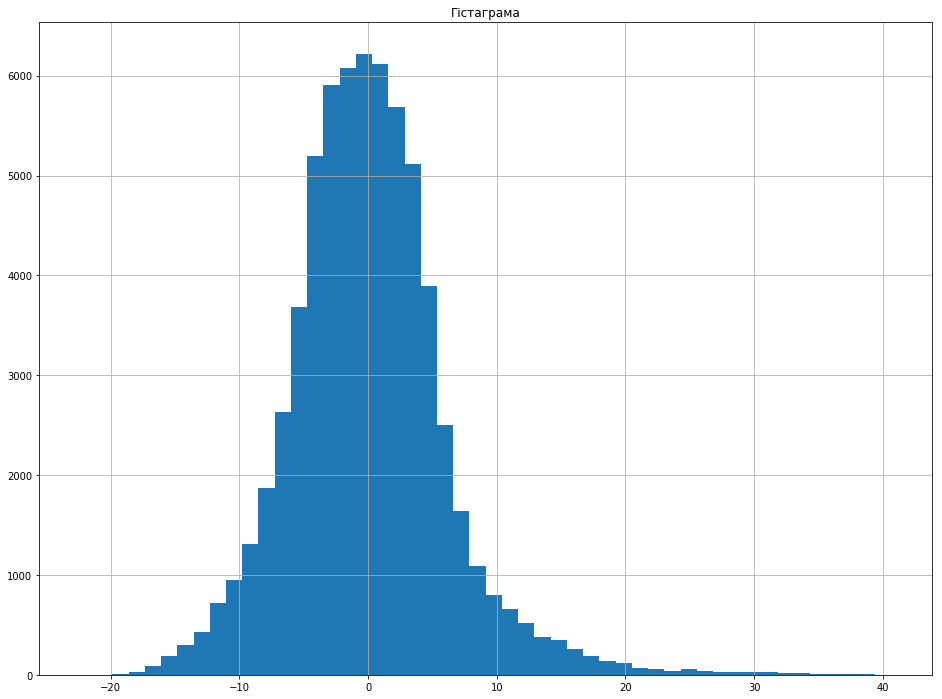

In [9]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.title("Гістаграма")
a = plt.hist(data, 50)

Розподіл схожий на нормальний

Нормалізуємо дані

In [10]:
data_norm = (data - data_mean) / np.sqrt(data_var)

In [11]:
data_norm_mean = data_norm.mean()
data_norm_var = data_norm.var()
print("Середнє: {}".format(data_norm_mean))
print("Дисперсія: {}".format(data_norm_var))

Середнє: 9.974659986866641e-18
Дисперсія: 1.0


Середнє значення дорінює 0, а дисперсія 1, отже, нормалізація пройшла успішно

Порівняємо аудіо до і після нормалізації

In [12]:
sd.play(data, fs)

In [13]:
sd.play(data_norm, fs)

Після нормалізації звук став трішки тихічим і шумів стало меньше(насправді вони просто стали також тихішими) <br>
Запишемо отриманий результат в аудіо файл

Оскілки нормалізовані дані виявились кращими тому надалі будемо використовувати саме їх

In [14]:
write('preliminary_analysis_data_norm.wav', fs, data_norm)

Автокореляційна функція

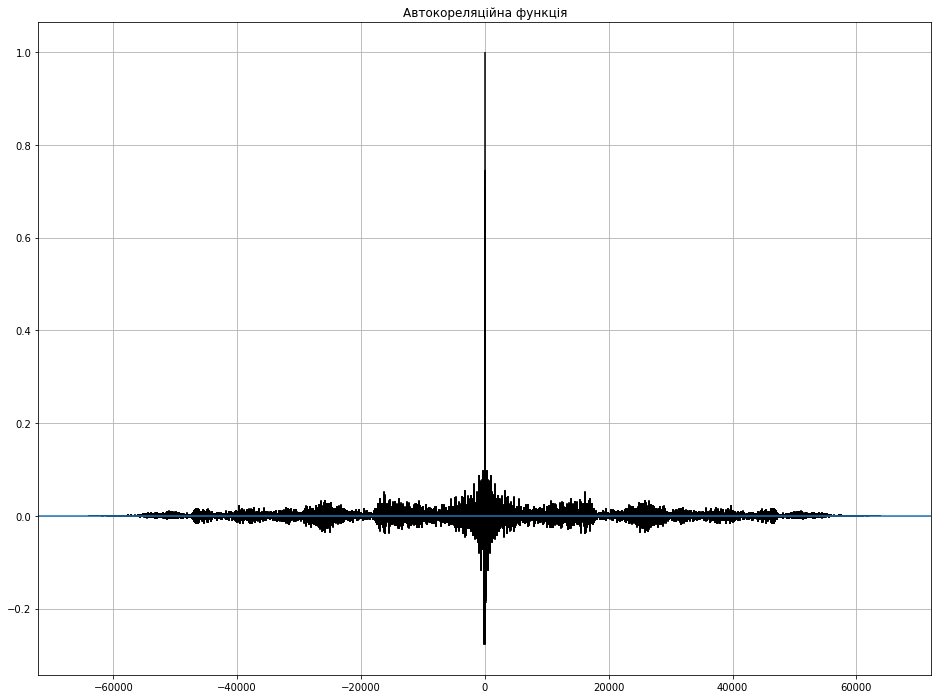

In [15]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.title('Автокореляційна функція')
plt.acorr(data_norm, maxlags=None);

Крос-кореляційна функцій між номером в послідовності і значенням функції

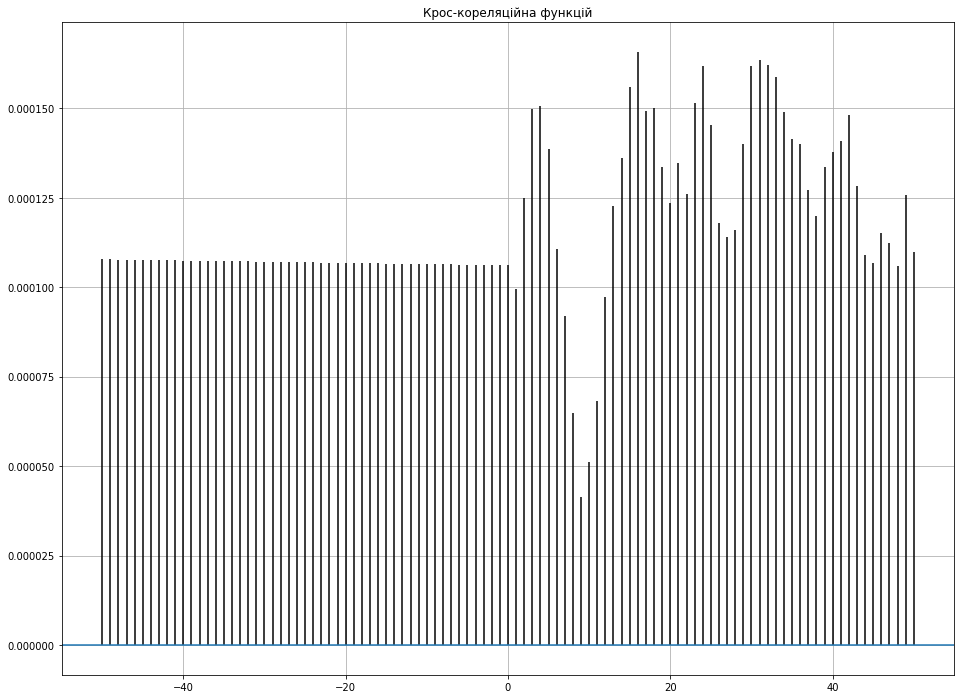

In [16]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.title('Крос-кореляційна функцій')
plt.xcorr(np.arange(data_len), data, maxlags=50);

### Висновок

На вхід нам надали зашумлений звуковий сигнал на котрому присутній голос людини. <br>
Підчас дослідження було найдено найкрашче значення кадрової частоти котре дорівнює 44.1 кГц. <br>
Гістаграма показала те, що розподіл сгналу схожий на нормальний, що також характерно для звукових сигналів. <br>
Нормалізація даних покращила звучання і тому в далі будемо використовувати саме нормалізовані дані. <br>
Автокореляційна і крос-кореляційна функції показують зміну кореляції в часі

# 2 Дисперсійний аналіз

Початковий сигнал можна розбити на 3 частини таким чином

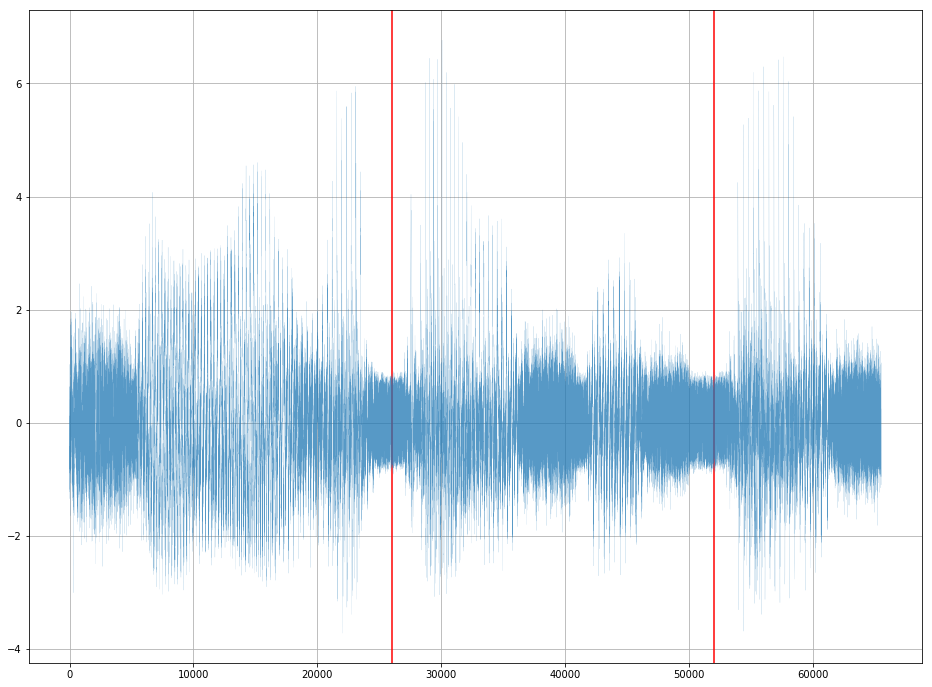

In [17]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.axvline(x=26000, c='r')
plt.axvline(x=52000, c='r')
plt.plot(data_norm, alpha=0.75, linewidth=0.1);

In [18]:
alpha = 0.95
g_alpha = 0.33

In [19]:
word_1 = data_norm[:26000] 
word_2 = data_norm[26000:52000]
word_3 = data_norm[52000:]
A = np.array([word_1, word_2, word_3])

In [20]:
S_i_2 = np.array([])
for word in A:
    S_i_2 = np.append(S_i_2, word.var(ddof=1))

In [21]:
print('Дисперсі кожного фактору')
S_i_2

Дисперсі кожного фактору


array([ 1.28189479,  0.7685088 ,  0.9033508 ])

In [22]:
g = max(S_i_2) / sum(S_i_2)
if g > g_alpha:
    print("Нульова гіпотиза про рівність дисперсій відхиляється")
else:
    print("Нульова гіпотиза про рівність дисперсій не відхиляється")

Нульова гіпотиза про рівність дисперсій відхиляється


### Висновок

Знаючи, що початковий сигнал це аудіозапис з голосом людини котра говорить декілька слів<br>
початковий сигнал можна розбити на декілька частин (у нашому випадку 3) по паузах між словами.<br>
І використовувати в якості факторів отримані частини сигналу. Гіпотизу про рівність <br>
дисперсій було відкинуто. Виходячи з метода побудови факторів про цей результат можна сказати, <br>
що для різних слів потрібні різні звуки і різна гучність.

# 3. Регресійний Аналіз

Перевіримо лінійний тренд, для цього найдемо коефіцієнти для лінійної апроксимації і дослідимо на адекватність побудовану модель

In [23]:
x = np.arange(data_len)
y = np.copy(np.abs(data_norm))
n = data_len

In [24]:
beta = ((x * y).mean() - x.mean() * y.mean()) / ((x**2).mean() - x.mean()**2)
alpha = y.mean() - beta * x.mean()

In [25]:
print('α = {}, β = {}'.format(alpha, beta))
print('y = {} + {}x'.format(np.round(alpha, 3), np.round(beta, 3)))

α = 0.9245391327882154, β = -5.539158676550044e-06
y = 0.925 + -0.0x


In [26]:
t = np.arange(x.min(), x.max(), 0.1)
z = alpha + beta * t

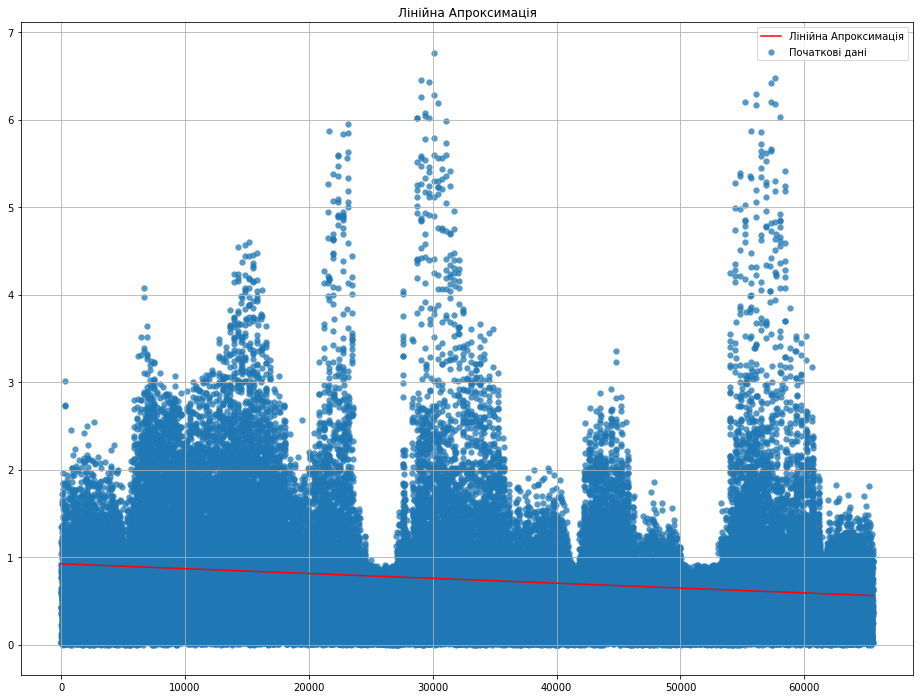

In [27]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.scatter(x, y, alpha=0.75, linewidth=0.2, label='Початкові дані');
plt.plot(t, z, 'r', label='Лінійна Апроксимація')
plt.title('Лінійна Апроксимація')
plt.legend();

In [28]:
def new_evaluation(x, y, e, S_i_2, R, R_delta):
    while R > R_delta:
        index_del_element = np.where((e / np.sqrt(S_i_2)) == np.max(np.abs(e / np.sqrt(S_i_2))))
        y[index_del_element] = y[index_del_element] / 2.5
        beta = ((x * y).mean() - x.mean() * y.mean()) / ((x**2).mean() - x.mean()**2)
        alpha = y.mean() - beta * x.mean()
        e = y - (alpha + beta * x)
        S_i_2 = ((e**2).sum() / (n - 2)) * (1 - (1 / n) - ((x - x.mean())**2) / ((x - x.mean())**2).sum())
        R = (e / np.sqrt(S_i_2)).max()
    print('Викидів нема')
    return x, y

Перевіримо наявність викидів, у випадку коли викиди є максимальне по модулю значення будимо зменьшувати в 2.5 рази і перераховувати чи залишились викиди чи ні.

In [29]:
e = y - (alpha + beta * x)
S_i_2 = ((e**2).sum() / (n - 2)) * (1 - (1 / n) - ((x - x.mean())**2) / ((x - x.mean())**2).sum())
R = (e / np.sqrt(S_i_2)).max()
R_delta = 4
if R > R_delta:
    print('Викиди є, протрібно їх викинути і провести оцінку спочатку')
    x, y = new_evaluation(x, y, e, S_i_2, R, R_delta)
else:
    print('Викидів нема')

Викиди є, протрібно їх викинути і провести оцінку спочатку
Викидів нема


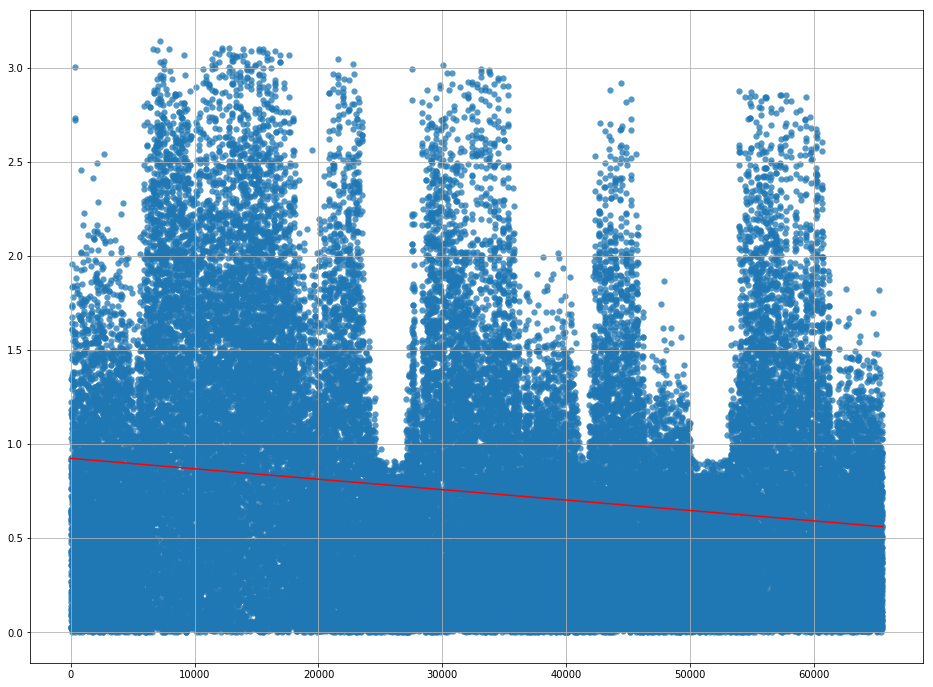

In [30]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.scatter(x, y, alpha=0.75, linewidth=0.2);
plt.plot(t, z, 'r');

Перевіримо на значущість коефіцієнти α та β

In [31]:
S_2 = ((y - alpha - beta * x)**2).sum() / (n - 2)
S_2_x = (((x - x.mean())**2).sum()) / (n - 1)
S_beta = np.sqrt(S_2) / (np.sqrt(S_2_x) * np.sqrt(n - 1))
t_delta = 1.645
if abs(beta) > t_delta * S_beta:
    print('Значення коефіцієнта β є значимим')
else:
    print('Значення коефіцієнта β є незначимим')

Значення коефіцієнта β є значимим


In [32]:
S_alpha = np.sqrt(S_2) * np.sqrt((1/n) + (x.mean()**2) / ((n-1) * S_2_x))
if abs(alpha) > t_delta * S_alpha:
    print('Значення коефіцієнта α є значимим')
else:
    print('Значення коефіцієнта α є незначимим')

Значення коефіцієнта α є значимим


Первіримо на адекватність модель

In [33]:
S_2_y = (((y - y.mean())**2).sum()) / (n - 1)
F_delta = 1
if S_2 / S_2_y < F_delta:
    print('Модель адекватна')
else:
    print('Модель не адекватна')

Модель адекватна


Порівняємо наскільки добре апроксимують початкові дані поліноми різної степені

In [34]:
z_1 = np.polyfit(x, y, 1)
z_2 = np.polyfit(x, y, 2)
z_3 = np.polyfit(x, y, 3)
linear_approximation = np.poly1d(z_1)
quadratic_approximation = np.poly1d(z_2)
cubic_approximation = np.poly1d(z_3)
print('Лінійна апрксимація:\n {}\n'.format(linear_approximation))
print('Квадратична апроксимація:\n {}\n'.format(quadratic_approximation))
print('Кубічна апрксимація:\n {}'.format(cubic_approximation))

Лінійна апрксимація:
  
-5.597e-06 x + 0.9013

Квадратична апроксимація:
            2
1.846e-11 x - 6.806e-06 x + 0.9145

Кубічна апрксимація:
            3             2
1.265e-14 x - 1.225e-09 x + 2.579e-05 x + 0.7365


In [35]:
S_2_1 = ((y - linear_approximation(x))**2).sum() / (n - 2)
S_2_2 = ((y - quadratic_approximation(x))**2).sum() / (n - 2)
S_2_3 = ((y - cubic_approximation(x))**2).sum() / (n - 2)
print('S_2 для лінійної апроксимації: {}'.format(S_2_1))
print('S_2 для квадратичної апроксимації: {}'.format(S_2_2))
print('S_2 для кубічної апроксимації: {}'.format(S_2_3))

S_2 для лінійної апроксимації: 0.32696524580229935
S_2 для квадратичної апроксимації: 0.32693032540272826
S_2 для кубічної апроксимації: 0.3224029846830966


Судячи по значеннях S_2 для кожного виду апроксимації можна зробити висновок, що найкраще з завданням ворась кубічна апроксимація,хоча різниця є доволі мала

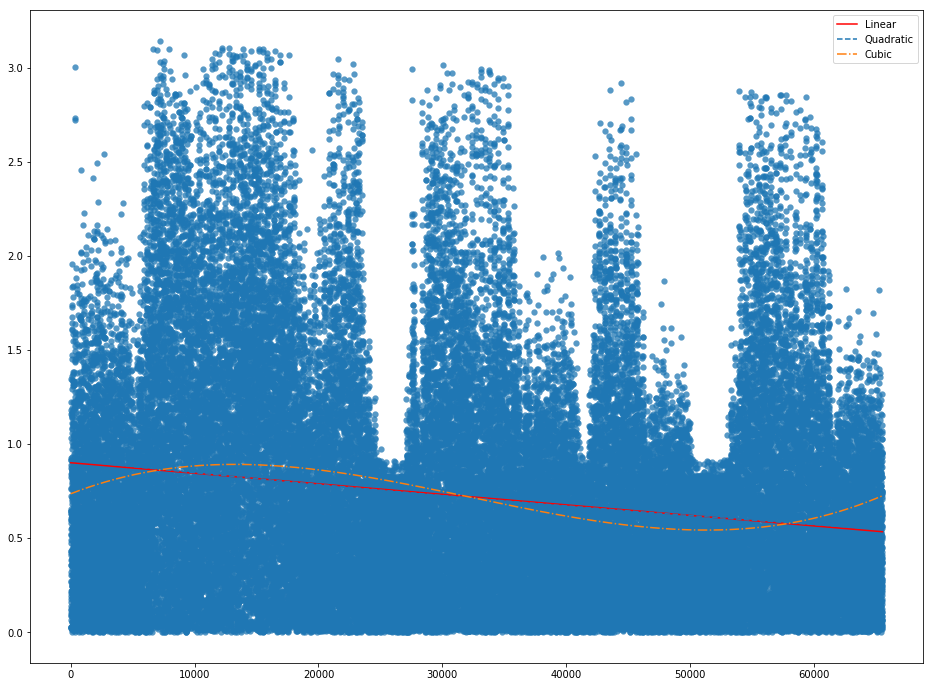

In [36]:
plt.figure(figsize=(16, 12))
plt.scatter(x, y, alpha=0.75, linewidth=0.2)
plt.plot(x, linear_approximation(x),'-',c='r', label='Linear')
plt.plot(x, quadratic_approximation(x), '--', label='Quadratic')
plt.plot(x, cubic_approximation(x), '-.',label='Cubic')
plt.legend();

Порівняємо звучання з викидами і без

In [37]:
sd.play(data_norm, fs)

In [38]:
sd.play(y, fs)

В подальшому дані з видаленими викидами не будуть використовуватися, оскільки вони не покращують звучання, не нормалізовані і змінені частини даних можуть відігравати важливу роль. Тому далі працюємо з звичайними нормованими вхідними даними.

In [39]:
x = np.arange(data_len)
y = np.copy(data_norm)

Спробуємо побудувати регресійну модель використовуючи періодичні функції sin і cos

In [40]:
def cos(x, a, b, c, d):
    return a * np.cos(b * x + c) + d

In [41]:
def sin(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

In [42]:
popt_cos, pcov_cos = curve_fit(cos, x, y)
print("Апроксимуюча функція {} * cos({}*x + {}) + {}".format(
    np.round(popt_cos[0], 5), 
    np.round(popt_cos[1], 5), 
    np.round(popt_cos[2], 5), 
    np.round(popt_cos[3], 5)))

Апроксимуюча функція -0.00357 * cos(1.0*x + 1.003) + -0.0


In [43]:
popt_sin, pcov_sin = curve_fit(sin, x, y)
print("Апроксимуюча функція {} * sin({}*x + {}) + {}".format(
    np.round(popt_sin[0], 5), 
    np.round(popt_sin[1], 5), 
    np.round(popt_sin[2], 5), 
    np.round(popt_sin[3], 5)))

Апроксимуюча функція 0.00504 * sin(0.99993*x + 3.35217) + -0.0


In [44]:
x = np.sin(6*np.pi/data_len*np.arange(data_len))

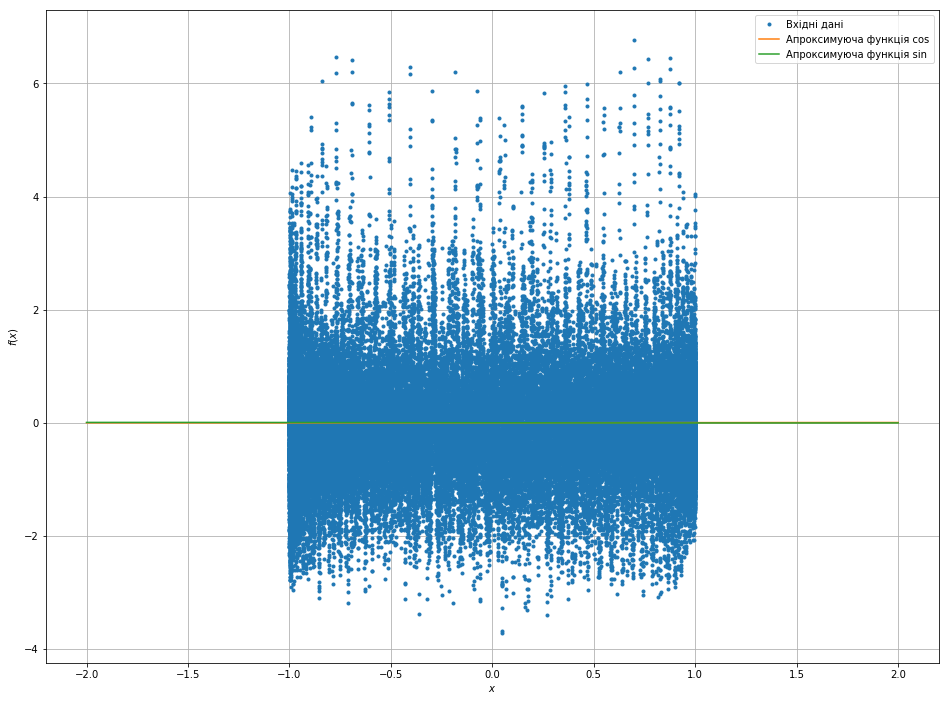

In [45]:
plt.figure(figsize=(16, 12))
xp = np.linspace(x.min()-1, x.max()+1, 100)
plt.plot(x, y, '.', label='Вхідні дані')
plt.plot(xp, cos(xp, popt_cos[0], popt_cos[1], popt_cos[2], popt_cos[3]), label='Апроксимуюча функція cos')
plt.plot(xp, sin(xp, popt_sin[0], popt_sin[1], popt_sin[2], popt_sin[3]), label='Апроксимуюча функція sin')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.grid(True)
plt.legend();

Порівняємо наскільки добре апроксимують початкові дані sin та cos і поліноми різних степеней дані з викидами

In [46]:
z_1 = np.polyfit(x, y, 1)
z_2 = np.polyfit(x, y, 2)
z_3 = np.polyfit(x, y, 3)
linear_approximation = np.poly1d(z_1)
quadratic_approximation = np.poly1d(z_2)
cubic_approximation = np.poly1d(z_3)
S_2_1 = ((y - linear_approximation(x))**2).sum() / (n - 2)
S_2_2 = ((y - quadratic_approximation(x))**2).sum() / (n - 2)
S_2_3 = ((y - cubic_approximation(x))**2).sum() / (n - 2)
print('S_2 для лінійної апроксимації: {}'.format(S_2_1))
print('S_2 для квадратичної апроксимації: {}'.format(S_2_2))
print('S_2 для кубічної апроксимації: {}'.format(S_2_3))

S_2 для лінійної апроксимації: 1.0000304362535397
S_2 для квадратичної апроксимації: 1.0000286680241002
S_2 для кубічної апроксимації: 1.0000285602160817


In [47]:
cos_func = cos(x, popt_cos[0], popt_cos[1], popt_cos[2], popt_cos[3])
sin_func = sin(x, popt_sin[0], popt_sin[1], popt_sin[2], popt_sin[3])

In [48]:
S_2_1 = ((y - sin_func)**2).sum() / (n - 2)
S_2_2 = ((y - cos_func)**2).sum() / (n - 2)
print('S_2 для sin апроксимації: {}'.format(S_2_1))
print('S_2 для cos апроксимації: {}'.format(S_2_2))

S_2 для sin апроксимації: 1.000038490414763
S_2 для cos апроксимації: 1.0000365103448423


### Висновок

Дослідження лінійної апроксимаці показало те, що коефіцієнти  α та β є не значними і модель виявилась неадекватною.
Порівнючи втрати при різних максималних степернях поліному виявилося що поліном 3 степені найкраще апроксимує дані  без викидів, проте покращення порівняно з лінійною і квадратичною апроксимацією доволі мале.<br>
Використовуючи апроксимацію sin та cos, та порівнючи її з апроксимаціями за допомогою поліномів було виявлено, що усі ці наближення майже не відрізняються між собою. Найкращою для даних з викидами виявилась кубічна апроксимація, а найгіршою cos. Поте навіть між найгіршим і найкращим результатом різниця занадто мала.

# 4.Аналіз Фур'є

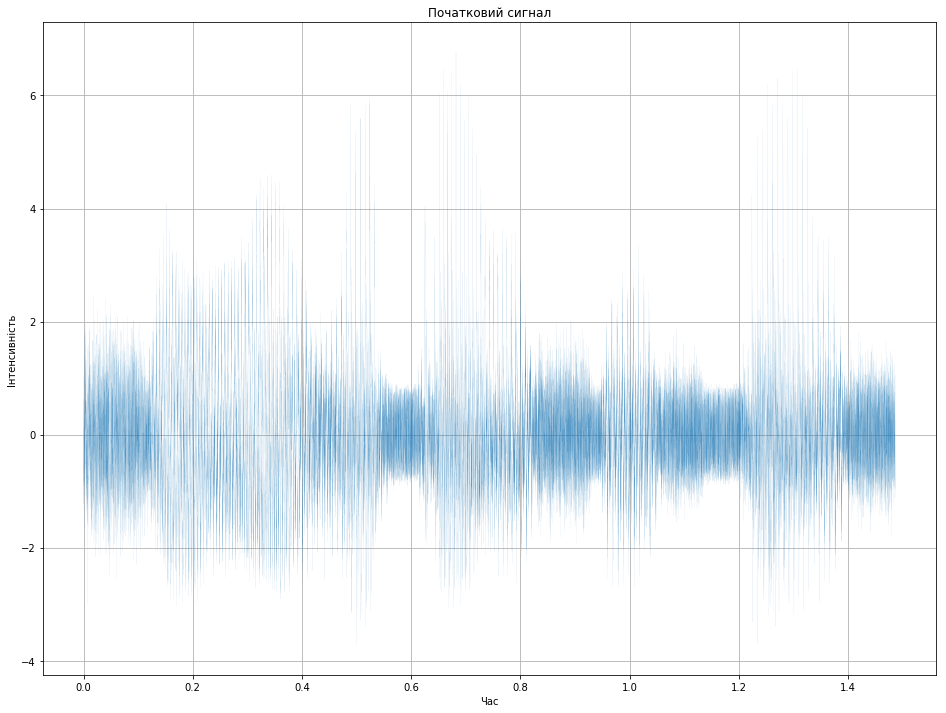

In [49]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.title('Початковий сигнал')
plt.xlabel('Час')
plt.ylabel('Інтенсивність')
plt.plot(np.arange(data_len)/fs, data_norm, alpha=0.75, linewidth=0.05);

Скористаємось перетворенням Фур'є для реальної послідовності

In [50]:
yf = scipy.fftpack.rfft(data_norm)

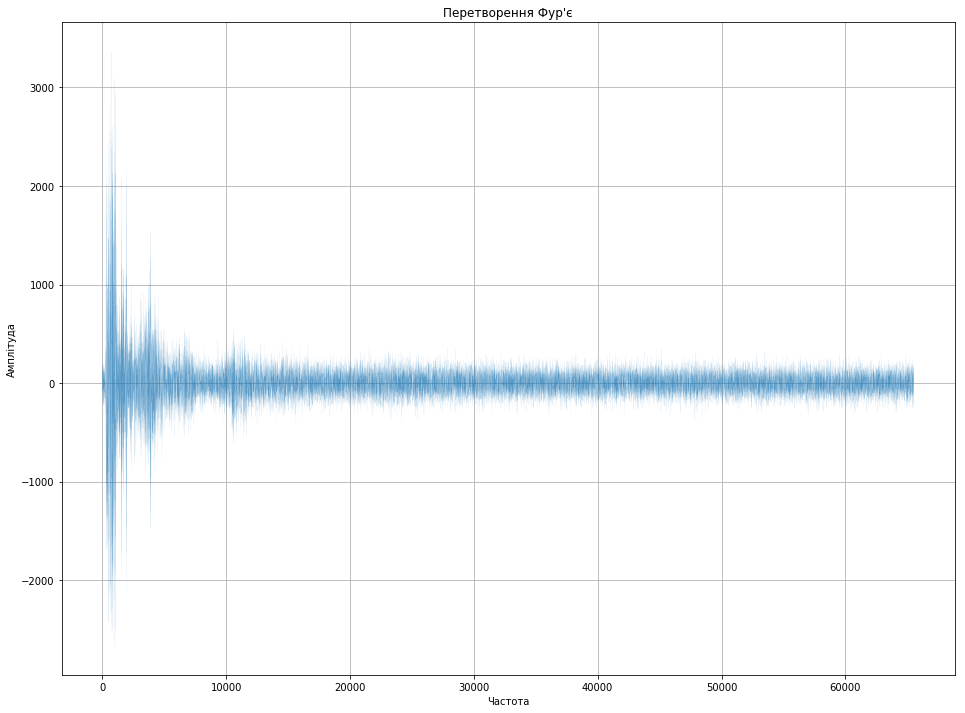

In [51]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.title("Перетворення Фур'є")
plt.xlabel('Частота')
plt.ylabel('Амплітуда')
plt.plot(yf, alpha=0.75, linewidth=0.05);

Як можна побачити з отриманого спектру при низьких частотах амплітуда велика, що може говорити про те, що звук сильно гуде. В свою чергу при великих значеннях частоти амплітуда не настільки валика але ізза того що частота висока звук буде погіршуватись (буде шипіти).<br>
Спробуємо покращити сигнал шляхом зміни аплітуди при високих і низьких частотах

Для цього скористаємось коротким перетворенням Фур'є оскільки візуалізація спектра для нього наглядніша і змінювати значиння певних частот для нього простіше

In [52]:
f, t, sfy = signal.stft(data_norm, fs)

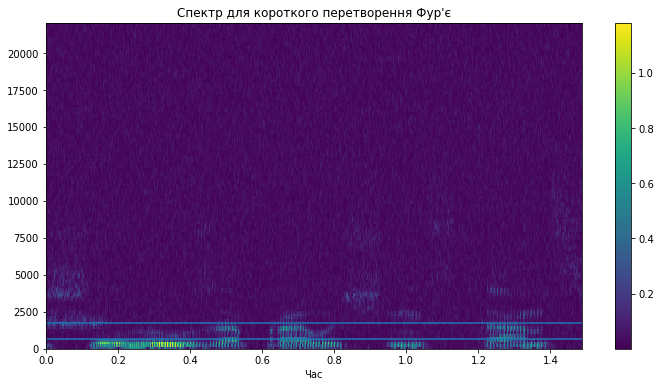

In [53]:
plt.figure(figsize=(12, 6))
plt.title("Спектр для короткого перетворення Фур'є")
plt.pcolormesh(t, f, np.abs(sfy))
plt.xlabel('Час')
plt.axhline(y=f[4])
plt.axhline(y=f[10])
plt.colorbar();

Аналізуючи отриману спектрограму можна сказати те, що шуми знаходяться між за межами стрічки між лініями. Для того щоб це дізнатись було пропедено дослідження підчас котрого частини з "цінною інформацією видалялись" і границя рухалась поки не зявлялассь цінна інформація. Таким чином можна було видалити лише шуми і залишити лиш текст

In [54]:
for i in range(len(sfy)):
    if i < 4 or i > 10:
        sfy[i, :] = sfy[i,:]/32

In [55]:
res = signal.istft(sfy)

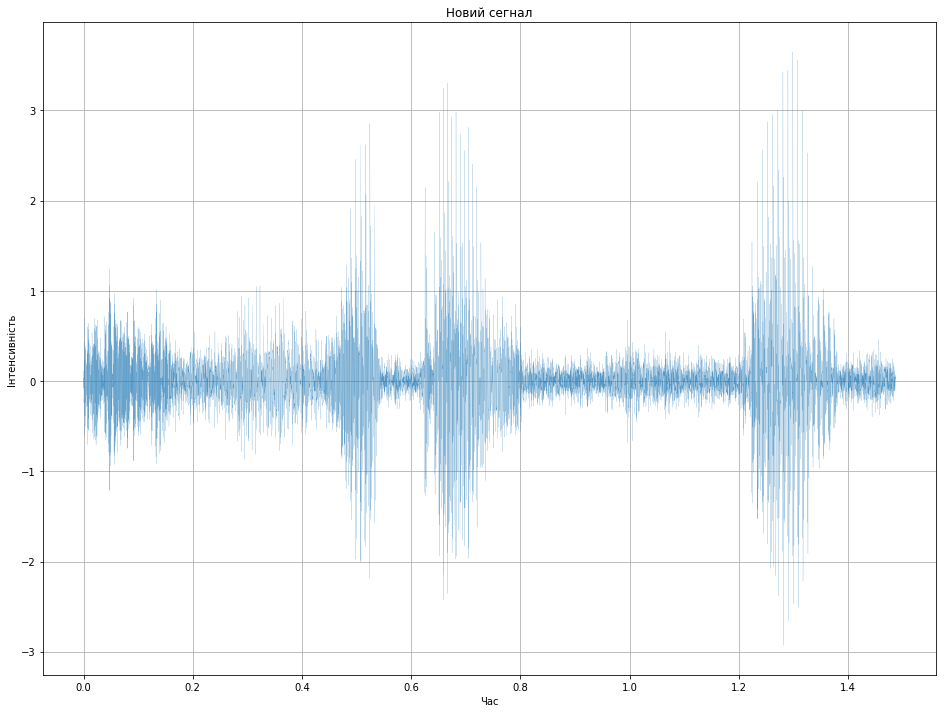

In [56]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.title('Новий сегнал')
plt.xlabel('Час')
plt.ylabel('Інтенсивність')
plt.plot(np.arange(data_len)/fs, res[1], alpha=0.75, linewidth=0.15);

Як можна побачити з отриманого графіка основна частина шумів була видалена<br>
Проівняєм наскільки покращився сигнал після видалення шумів

In [57]:
sd.play(res[1], fs)

In [58]:
sd.play(data_norm, fs)

Аудофайл значно покращився в звучанні<br>
Збережемо нову версію аудіо

In [59]:
write('crear_use_fourier_transform.wav', fs, res[1])

Спробуємо пронормувати дані, це може покращити звучання

In [60]:
res_mean = res[1].mean()
res_var = res[1].var()

In [61]:
res_norm = (res[1] - res_mean) / np.sqrt(res_var)

Поріняєм з ненормованими даними

In [62]:
sd.play(res[1], fs)

In [63]:
sd.play(res_norm, fs)

Нормування не дало суттєвого приросту в якості, збільшилась лиш гучність. <br>
Збережемо нормовану версію аудіо очищеного з використанням перетворення Фур'є

In [64]:
write('crear_use_fourier_transform_norm.wav', fs, res_norm)

### Висновок

Проводячи аналіз Фур'є було виявлено основні причини шуму на аудіозаписі, а саме високочистотний і ниськочистотний шуми. Для покращення аудіозапису було знайдено частину даних котра відповідає за основну інформацію(текст диктора) на аудіо і відкинуто шляхом зменьшення інтенсивності усе інше. В результаті проведеної роботи було отримано очищений від шуму звуковий сегнал, котрий краще звучав ніж просто нормований сегнал. Після цього було пероведено нормалізацію очищеного сегналу, проте це на дало суттєвого результату. Отже, використовуючи перетворення фурє можна зменьшити кількість шумів і покращити якість початкового сегналу.

# Вейвлет аналіз

### Вейвлет Хаара

In [65]:
haar_coefs = pywt.wavedec(data_norm, 'haar', level=16)

In [66]:
max_shape = haar_coefs[-1].shape[0]

In [67]:
new_haar_coefs = []
for i in tqdm_notebook(range(len(haar_coefs))):
    new_line = np.array([])
    len_old_line = len(haar_coefs[i])
    for j in haar_coefs[i]:
        for k in range(max_shape//len_old_line):
            new_line = np.append(new_line, j)
    new_haar_coefs.append(new_line)

A Jupyter Widget

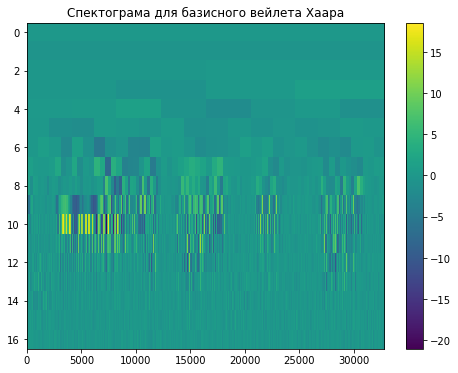

In [68]:
plt.figure(figsize=(8,6))
plt.imshow(new_haar_coefs, aspect='auto')
plt.title("Спектограма для базисного вейлета Хаара")
plt.colorbar();

Аналізуєчи отриману спектограму можна чітко пабачити 4 неоднорідності, скоріш всьо це є слова на аудіозаписі.
На 9 і 10 рівні перша неоднорідність має більший розмір, можливо ці рівні є ключовими, тобто в них знаходяться слова.

Видалимо шуми шляхом встановлення граничного значення

In [69]:
haar_sigma = mad(haar_coefs[-1])
haar_uthresh = haar_sigma*np.sqrt(2*np.log(len(data_norm)))

haar_denoised = haar_coefs[:]

haar_denoised[1:] = (pywt.threshold(i, value=haar_uthresh) for i in haar_denoised[1:])

In [70]:
haar_signal = pywt.waverec(haar_denoised, 'haar')

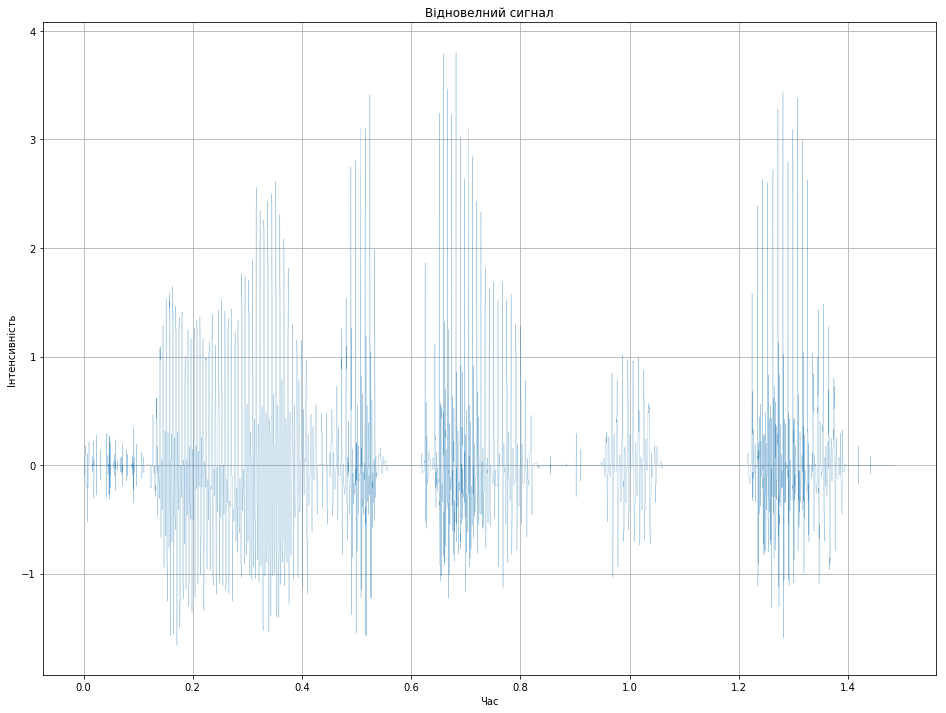

In [71]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.title('Відновелний сигнал')
plt.xlabel('Час')
plt.ylabel('Інтенсивність')
plt.plot(np.arange(data_len)/fs, haar_signal, alpha=0.75, linewidth=0.25);

Порівняєм з звучанням вхідних даних і з нормованими відновленимим даними

In [72]:
haar_signal_norm = (haar_signal - haar_signal.mean()) / np.sqrt(haar_signal.var())

In [73]:
sd.play(data_norm, fs)

In [74]:
sd.play(haar_signal, fs)

In [75]:
sd.play(haar_signal_norm, fs)

В відновленому сигналі немає шумів проте набагато гірше чути слова тому використовувати вейвлет Хаара для очищення сегналу не найкращий вибір

In [76]:
write('haar_signal_norm.wav', fs, haar_signal_norm)

### Вейвлет Дебаучі

In [77]:
db_coefs = pywt.wavedec(data_norm, 'db8', level=12, mode='per')

In [78]:
max_shape = db_coefs[-1].shape[0]

In [79]:
new_db_coefs = []
for i in tqdm_notebook(range(len(db_coefs))):
    new_line = np.array([])
    len_old_line = len(db_coefs[i])
    for j in db_coefs[i]:
        for k in range(max_shape//len_old_line):
            new_line = np.append(new_line, j)
    new_db_coefs.append(new_line)

A Jupyter Widget

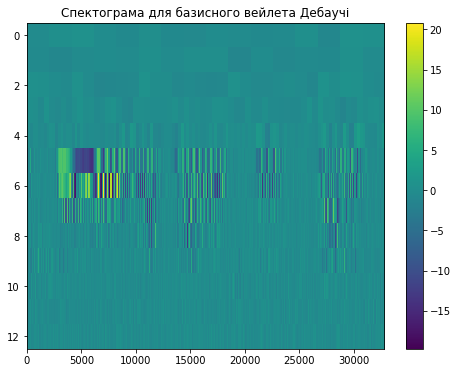

In [80]:
plt.figure(figsize=(8,6))
plt.imshow(new_db_coefs, aspect='auto')
plt.title("Спектограма для базисного вейлета Дебаучі")
plt.colorbar();

Аналізуєчи отриману спектограму можна чітко пабачити 4 неоднорідності, скоріш всьо це є слова на аудіозаписі.
На 5, 6, 7 рівні перша неоднорідність має більший розмір, можливо ці рівні є ключовими.

In [81]:
db_sigma = mad(db_coefs[-1])
db_uthresh = db_sigma*np.sqrt(2*np.log(len(data_norm)))

db_denoised = db_coefs[:]

db_denoised[1:] = (pywt.threshold(i, value=db_uthresh) for i in db_denoised[1:])

In [82]:
db_signal = pywt.waverec(db_denoised, 'db8', mode='per')

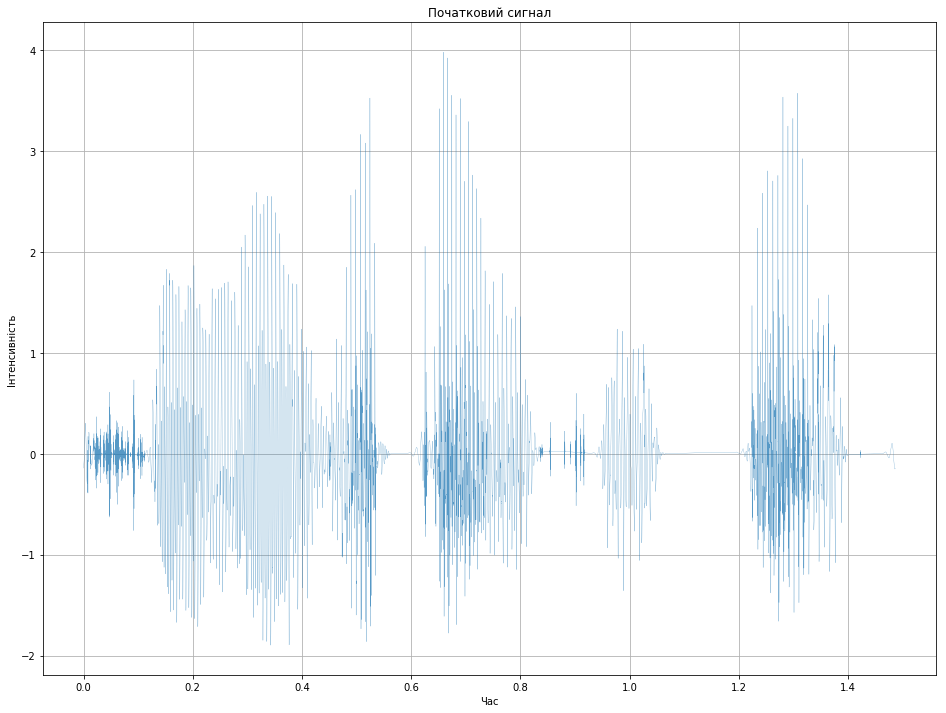

In [83]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.title('Початковий сигнал')
plt.xlabel('Час')
plt.ylabel('Інтенсивність')
plt.plot(np.arange(data_len)/fs, db_signal, alpha=0.75, linewidth=0.25);

In [84]:
db_signal_norm = (db_signal - db_signal.mean()) / np.sqrt(db_signal.var())

In [85]:
sd.play(data_norm, fs)

In [86]:
sd.play(db_signal, fs)

In [87]:
sd.play(db_signal_norm, fs)

Вейвлет Дебаучі працію краще ніж вейвлет Хаара і по якості може конкурувати з початковими нормованимим даними, нормування даних не дало суттєвого покращення 

In [88]:
write('db_signal_norm.wav', fs, db_signal_norm)

### Висновок 

Використовуючи вейвлети Хаара та Дебаучі можна покращити звучання аудіозапису шляхом видалення шумів, проте після видалення шумів залишаюстья низькі частоти котрі добавляють "гудіння" в текст. Вейвлет Хаара гірше підходить для даної задачі оскільки після перетворення всерівно залишаються шуми та текст звучить обривисто. В совоючергу вейвлет Дебаучі краще підходить для цьої задачі оскільки він видаляє потрібну кількість, але всерівно залишається шудіння яке повязане з низькими частотами. 

# Висновки

Вхідними даними був зашумлений аудіозапис. Підчас роботи було розглянуто різни методи для позбавлення запису шуму. Найкращим виявився метод видалення певних частот задопомогою короткого перетворення Фур'є. Методи Вейвлет аналізу виявились не настільки хорошими як перетворення Фур'є (якщо оцінувати якість за допомогою порівняння чіткості слів), але після видалення шуму за допомогою вейлета Дебаучі шумів не залишилось, а залишилось лише гудіння ізза низьких частот котрі залишились.

Для перевірик роботи видалення шумів за допомогою вейлета Дебаучі було також перевірено інший варіант(1), результат виявився майже ідеальний

In [89]:
data1 = np.loadtxt('ff1.txt')
data1_norm = (data1 - data1.mean()) / np.sqrt(data1.var())

In [90]:
db_coefs1 = pywt.wavedec(data1_norm, 'db8', level=12, mode='per')

In [91]:
db_sigma1 = mad(db_coefs1[-1])
db_uthresh1 = db_sigma1*np.sqrt(2*np.log(len(data1_norm)))

db_denoised1 = db_coefs1[:]

db_denoised1[1:] = (pywt.threshold(i, value=db_uthresh1) for i in db_denoised1[1:])

In [92]:
db_signal1 = pywt.waverec(db_denoised1, 'db8', mode='per')

In [93]:
db_signal_norm1 = (db_signal1 - db_signal1.mean()) / np.sqrt(db_signal1.var())

In [94]:
sd.play(data1_norm, fs)

In [95]:
sd.play(db_signal1, fs)

In [96]:
sd.play(db_signal_norm1, fs)

In [97]:
write('ideal.wav', fs, db_signal_norm1)